# Step 1.Reading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive')


In [4]:
from data_resampling import process_data

# Example usage
data_path = '/content/drive/My Drive/eDO_data_M1.csv'
resampled_data = process_data(data_path)
resampled_data.head()


/content/drive/My Drive/data_resampling.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample('1H').agg({


,open,high,low,close,volume,future_close,pct_change,Target,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,close_lag_8,close_lag_9,close_lag_10,MA_3
TimeStamp,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,47143.98,47298.75,46715.39,46871.08,923.01760,47391.82,1.111005,C,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46811.77,46778.14,46656.13,47046.626667
2022-01-01 11:00:00,46871.09,47007.73,46756.77,46758.87,732.88793,47319.67,1.199345,C,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46811.77,46778.14,46924.643333
2022-01-01 12:00:00,46758.87,47150.48,46756.30,47074.05,582.15009,47440.74,0.778964,C,46758.87,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46811.77,46901.333333
2022-01-01 13:00:00,47074.05,47199.67,46935.09,47023.24,454.14412,47722.65,1.487371,C,47074.05,46758.87,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,46813.20,46952.053333
2022-01-01 14:00:00,47023.24,47100.00,46850.18,46926.22,503.66220,47625.30,1.489743,C,47023.24,47074.05,46758.87,46871.08,47143.98,47124.82,47194.73,46979.62,47192.55,46711.05,47007.836667


# Step 2: Model Selection and Training
Choose a machine learning model like  XGBoost,

## XGBOOSt

Data index range: 2022-01-01 10:00:00 to 2024-12-08 21:00:00
Train data shape: (24756, 19)
Test data shape: (910, 19)
X_train shape: (24756, 18), y_train shape: (24756,)
X_test shape: (910, 18), y_test shape: (910,)
Root Mean Squared Error (RMSE): 0.0673
R^2 Score: 0.9832


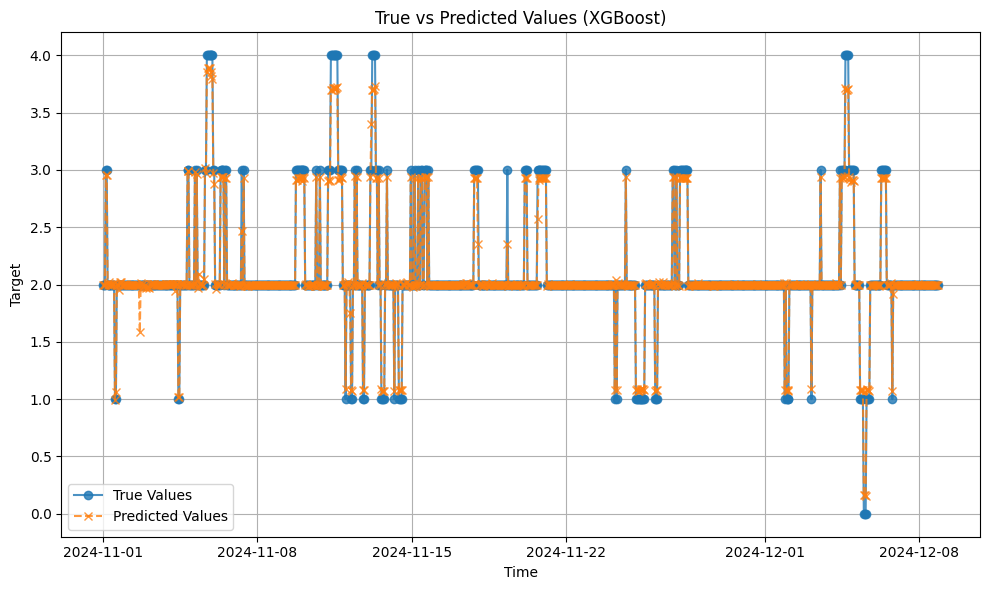

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Target column is numeric
label_encoder = LabelEncoder()
resampled_data['Target'] = label_encoder.fit_transform(resampled_data['Target'])



# Debugging: Check the index range of resampled_data
print(f"Data index range: {resampled_data.index.min()} to {resampled_data.index.max()}")

# Define features (X) and target (y)
X = resampled_data.drop(columns=['Target'])  # Features
y = resampled_data['Target']  # Target

# Encode target column if it contains categories
if y.dtypes == 'object':
    y, uniques = pd.factorize(y)  # Convert categorical targets to numeric values
    print(f"Target categories: {uniques}")

# Split the data into training and testing sets
train_data = resampled_data[resampled_data.index < '2024-11-01']
test_data = resampled_data[resampled_data.index >= '2024-11-01']

# Check train and test data shapes
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Ensure train_data and test_data are non-empty
if train_data.empty or test_data.empty:
    raise ValueError("Train or test data is empty. Check your date split condition.")

X_train = train_data.drop(columns=['Target'])
y_train = train_data['Target']
X_test = test_data.drop(columns=['Target'])
y_test = test_data['Target']

# Debugging: Check if features and targets are empty
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

if X_train.empty or X_test.empty:
    raise ValueError("Train or test feature set is empty. Verify your train-test split.")

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "reg:squarederror",  # Regression objective
    "max_depth": 6,
    "eta": 0.1,  # Learning rate
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on test data
y_pred = xgb_model.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot True vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True Values", alpha=0.8, marker='o')
plt.plot(y_test.index, y_pred, label="Predicted Values", alpha=0.8, linestyle='--', marker='x')
plt.title("True vs Predicted Values (XGBoost)")
plt.xlabel("Time")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
df_counts_sorted = pd.DataFrame({
               'Train': train_data.Target.value_counts(),
               'Test': test_data.Target.value_counts()}).sort_index()                                             .sort_index()

df_counts_sorted

,Train,Test
Target,,
0,314,3
1,1752,47
2,20397,732
3,1970,105
4,323,23


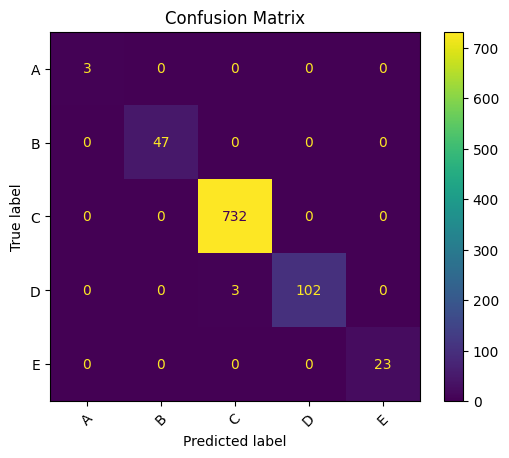

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Round predictions to the nearest integer and ensure valid class indices
y_pred_rounded = np.round(y_pred).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.show()